# Virtually Straining a Biological Tissue with a Conditional GAN

The virtual_staining.ipynb notebook provides you with a complete code example to virtually stain a biological tissue with a conditional GAN

## Downloading the Human Motor Neurons Dataset

You’ll use a dataset that was originally published in the article: E. M. Christiansen et al., Cell 173:792-803, 2018. Specifically, you’ll use the human motor neurons dataset that is designated as “Condition A” in the article. This dataset comprises 22 pairs of brightfield and corresponding fluorescent images, with each pair including spatially registered images showcasing two fluorescent channels: Hoechst stain, revealing nuclei with a blue stain, and anti-TuJ1 stain, highlighting neurons in green. Notably, the brightfield images encompass a z-stack of 13 images across different focal planes, offering a comprehensive view of the cellular structures in question.

Download the dataset from Google Storage. The dataset is about 10 GB and will take at least a few minutes to download, or longer depending on your internet connection.

In [5]:
import os, subprocess

url = "gs://in-silico-labeling/paper_data/"
path = "virtual_staining_dataset"
if not os.path.exists(path):
    for dataset in ['train', 'test']:
        dataset_url = url + dataset + "/Rubin/scott_1_0"
        dataset_dir = os.path.join(path, dataset)
        os.makedirs(dataset_dir, exist_ok=True)
        
        command = ["gsutil", "-m", "cp", "-r", dataset_url, dataset_dir]
        subprocess.run(command, check=True)

If you experience problems with multiprocessing on MacOS, they might be related to https://bugs.python.org/issue33725. You can disable multiprocessing by editing your .boto config or by adding the following flag to your command: `-o "GSUtil:parallel_process_count=1"`. Note that multithreading is still available even if you disable multiprocessing.

Copying gs://in-silico-labeling/paper_data/train/Rubin/scott_1_0/lab-Rubin,condition-scott_1_0,acquisition_date,year-2016,month-2,day-6,well-r02c05,depth_computation,value-MAXPROJECT,is_mask-false,kind,value-ORIGINAL.png...
Copying gs://in-silico-labeling/paper_data/train/Rubin/scott_1_0/lab-Rubin,condition-scott_1_0,acquisition_date,year-2016,month-2,day-6,well-r02c05,depth_computation,value-MAXPROJECT,statistic,value-MEDIAN,kind,value-PREDICTED.png...
Copying gs://in-silico-labeling/paper_data/train/Rubin/scott_1_0/lab-Rubin,condition-scott_1_0,acquisition_date,year-2016,month-2,day-6,well-r02c05,z_depth-0,channel,value-BRIGHTFIELD,is_mask

## Creating a Dataset

Implement a class containing the dataset ...

In [7]:
import glob
import numpy as np
import torch
from PIL import Image
from torch.utils.data import Dataset
from tqdm import tqdm

class VirtualStainingDataset(Dataset):
    """Dataset containing the brighfield and fluorescence images."""

    _cache = {}  # Class variable to cache loaded images.

    def __init__(self, root, train=True, transform=None, preload=False):
        """Initialize dataset."""
        self.transform = transform
        self.preload = preload
        self.images = []

        if train:  # Train directory.
            self.image_dir = os.path.join(root, "train", "scott_1_0")
        else:  # Test directory.
            self.image_dir = os.path.join(root, "test", "scott_1_0")
        pattern = ("lab-Rubin,condition-scott_1_0,acquisition_date,"
                   "year-2016,month-2,day-6,"
                   "well-r0*c0*,"
                   "depth_computation,"
                   "value-MAXPROJECT,is_mask-false,kind,value-ORIGINAL.png")   
        self.image_list = glob.glob(os.path.join(self.image_dir, pattern))

        self.cache_key = self.image_dir
        if self.preload:
            if self.cache_key in VirtualStainingDataset._cache:
                self.images = VirtualStainingDataset._cache[self.cache_key]
            else:
                for image_path in tqdm(self.image_list,
                                       total=len(self.image_list),
                                       desc="Preloading images"):
                    self.images.append(self.load_image(image_path))
                VirtualStainingDataset._cache[self.cache_key] = self.images

    def __len__(self):
        """Return number of images."""
        return len(self.image_list)

    def __getitem__(self, idx):
        """Get next input-target image couple."""
        if self.preload:
            input_image, target_image = self.images[idx]
        else:
            input_image, target_image = self.load_image(self.image_list[idx])

        if self.transform:
            seed = np.random.randint(1_000_000_000)
            
            torch.manual_seed(seed)
            input_image = self.transform[0](input_image)

            torch.manual_seed(seed)
            target_image = self.transform[1](target_image)

        return input_image, target_image

    def load_image(self, image_path):
        """Load input-target image couple."""
        input_image = []
        for i in range(0, 13):
            img_path = (image_path
                        .replace("depth_computation", f"z_depth-{i},channel")
                        .replace("value-MAXPROJECT", "value-BRIGHTFIELD"))
            input_image.append(np.array(Image.open(img_path).convert("L")))
        input_image = np.stack(input_image, axis=-1)

        target_image = np.array(Image.open(image_path))

        return input_image, target_image

... define the image transformations and normalizations ...

In [8]:
from torchvision import transforms

trans_bright = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean=[0.5] * 13, std=[0.5] * 13)
])
trans_fluorescent = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop((256, 256)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
])

... create the training and testing datasets ...

In [9]:
train_dataset = VirtualStainingDataset(
    root="virtual_staining_dataset",
    train=True,
    transform=[trans_bright, trans_fluorescent],
    preload=True,
)
test_dataset = VirtualStainingDataset(
    root="virtual_staining_dataset",
    train=False,
    transform=[trans_bright, trans_fluorescent],
    preload=True,
)

Preloading images: 100%|██████████| 3/3 [00:12<00:00,  4.09s/it]


... and visualize brightfield and corresponding fluorescence images.

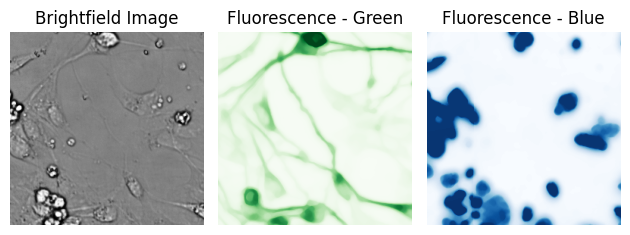

In [12]:
import matplotlib.pyplot as plt

bf_img, fl_img = train_dataset[np.random.randint(0, len(train_dataset))]

def denormalize(image):
    """Denormalize images for visualization."""
    return (image + 1) / 2

plt.figure()

plt.subplot(1, 3, 1)
plt.imshow(bf_img.mean(axis=0), cmap="gray")
plt.title("Brightfield Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(denormalize(fl_img[1, :, :].numpy()), cmap="Greens")
plt.title("Fluorescence - Green")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(denormalize(fl_img[2, :, :].numpy()), cmap="Blues")
plt.title("Fluorescence - Blue")
plt.axis("off")

plt.tight_layout()
plt.show()

## Instantiating the Generator and Discriminator

Determine the device to be used in the computations ...

In [13]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

... define the generator ...

In [47]:
import deeplay as dl
import torch.nn as nn

generator = dl.UNet2d(
    in_channels=13,
    channels=[32, 64, 128, 256, 512],
    out_channels=3,
)
generator[..., "activation"].configure(nn.LeakyReLU, negative_slope=0.2)
generator["decoder", ..., "activation#-1"].configure(nn.Tanh)
generator["decoder", "blocks", :-1].all.normalized(nn.InstanceNorm2d)
generator[..., "blocks"].configure(order=["layer", "normalization", "activation"])
generator.build()
generator.to(device);

print(generator)

UNet2d(
  (encoder): ConvolutionalEncoder2d(
    (blocks): LayerList(
      (0): Conv2dBlock(
        (layer): Conv2d(13, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (1): Conv2dBlock(
        (layer): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (2): Conv2dBlock(
        (layer): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (3): Conv2dBlock(
        (layer): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
      (4): Conv2dBlock(
        (layer): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (activation): LeakyReLU(negative_slope=0.2)
      )
    )
    (postprocess): Identity()
  )
  (bottleneck): ConvolutionalNeuralNetwork(
    (b

... and define the discriminator.

In [44]:
discriminator = dl.ConvolutionalNeuralNetwork(
    in_channels=16,
    hidden_channels=[8, 16, 32, 64],
    out_channels=1,
)
discriminator["blocks", ..., "layer"] \
    .configure(kernel_size=4, stride=2, padding=1)
discriminator["blocks", ..., "activation#:-1"] \
    .configure(nn.LeakyReLU, negative_slope=0.2)
discriminator["blocks", 1:-1].all.normalized(nn.InstanceNorm2d)
discriminator["blocks", ..., "activation#-1"].configure(nn.Sigmoid)
discriminator["blocks"] \
    .configure(order=["layer", "normalization", "activation"])
discriminator.build()
discriminator.to(device);

print(discriminator)

ConvolutionalNeuralNetwork(
  (blocks): LayerList(
    (0): Conv2dBlock(
      (layer): Conv2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (1): Conv2dBlock(
      (layer): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (normalization): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (2): Conv2dBlock(
      (layer): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (normalization): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.2)
    )
    (3): Conv2dBlock(
      (layer): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (normalization): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (activation): LeakyReLU(negative_slope=0.

## Compiling the Conditional GAN

Define the losses ...

In [ ]:
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

loss_D = torch.nn.MSELoss()
loss_G = torch.nn.L1Loss()
loss_LPIPS = LearnedPerceptualImagePatchSimilarity(net_type="vgg").to(device)

... define the optimizers ...

In [ ]:
generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002,
                                       betas=(0.5, 0.999))
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(),
                                           lr=0.00005, betas=(0.5, 0.999))

... and define the data loaders.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=2,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, 
                                          shuffle=True)

## Training the Conditional GAN

Define a function to train the discriminator ...

In [ ]:
def train_discriminator(inputs, targets, optimizer, loss_D=loss_D):
    """Train the discriminator."""
    generator.train()
    optimizer.zero_grad()

    # Compute real loss.
    output_real = discriminator(torch.cat([inputs, targets], dim=1))
    label_real = torch.ones_like(output_real)
    loss_real = loss_D(output_real, label_real)

    # Compute fake loss.
    output_fake = discriminator(torch.cat([inputs, generator(inputs)], dim=1))
    label_fake = torch.zeros_like(output_fake)
    loss_fake = loss_D(output_fake, label_fake)

    loss = (loss_real + loss_fake) / 2
    loss.backward()
    optimizer.step()
    
    return loss

... define a function to train the generator ...

In [ ]:
def train_generator(inputs, targets, optimizer, loss_D=loss_D, loss_G=loss_G,
                    loss_LPIPS=loss_LPIPS, L1_Lambda=100, LPIPS_Lambda=10):
    """Train the generator."""
    optimizer.zero_grad()

    generator_output = generator(inputs)
    discriminator_output = discriminator(torch.cat([inputs, generator_output], 
                                                    dim=1))
    
    label = torch.ones_like(discriminator_output)
    loss_GAN = loss_D(discriminator_output, label)
    loss_L1 = loss_G(generator_output, targets)
    loss_P = loss_LPIPS(generator_output, targets)
    
    loss = loss_GAN + L1_Lambda * loss_L1 + LPIPS_Lambda * loss_P
    loss.backward()
    optimizer.step()

    return loss_GAN, loss_L1, loss_P


... and a function to evaluate the model on the test dataset ...

In [ ]:
def evaluate_model(image, label):
    """Evaluate model on test data."""
    generator.eval()
    with torch.no_grad():
        prediction = generator(image)

    fig, ax = plt.subplots(2, 3, figsize=(10, 5))

    ax[0, 0].imshow(
        denormalize(image[0].permute(1, 2, 0).cpu().numpy().mean(axis=-1)), 
        cmap="gray"
    )
    ax[0, 0].axis("off")
    ax[0, 0].set_title("Input Image")

    ax[0, 1].imshow(
        denormalize(prediction[0].permute(1, 2, 0).cpu().numpy())[:, :, 1], 
        cmap="Greens",
    )
    ax[0, 1].axis("off")
    ax[0, 1].set_title("Prediction - Green")

    ax[1, 1].imshow(
        denormalize(label[0].permute(1, 2, 0).cpu().numpy())[:, :, 1], 
        cmap="Greens",
    )
    ax[1, 1].axis("off")
    ax[1, 1].set_title("Ground truth - Green")

    ax[0, 2].imshow(
        denormalize(prediction[0].permute(1, 2, 0).cpu().numpy())[:, :, 2], 
        cmap="Blues",
    )
    ax[0, 2].axis("off")
    ax[0, 2].set_title("Prediction - Blue")

    ax[1, 2].imshow(
        denormalize(label[0].permute(1, 2, 0).cpu().numpy())[:, :, 2], 
        cmap="Blues",
    )
    ax[1, 2].axis("off")
    ax[1, 2].set_title("Ground truth - Blue")

    ax[1, 0].axis("off")  # Leave the [1, 0] subplot empty.

    plt.tight_layout()
    plt.show()

... and implement the training cycle.

In [ ]:
epochs, L1_Lambda, LPIPS_Lambda = 500, 100, 10

for epoch in range(epochs + 1):
    for i, (inputs, labels) in enumerate(train_loader, 0):
        print(f"{epoch} - {i}")
        inputs, labels = inputs.to(device), labels.to(device)

        # 1. Train the discriminator.
        disc_loss = train_discriminator(
            inputs=inputs, 
            targets=labels, 
            optimizer=discriminator_optimizer,
        )

        # 2. Train the generator.
        for _ in range(2):
            adv_loss, rec_loss, percep_loss = train_generator(
                inputs=inputs, 
                targets=labels, 
                optimizer=generator_optimizer, 
                L1_Lambda=L1_Lambda, 
                LPIPS_Lambda=LPIPS_Lambda,
            )

        gen_loss = adv_loss + rec_loss + percep_loss

    if epoch % 50 == 0:
        for i, data, in enumerate(test_loader, 0):
            test_inputs, test_labels = data
            test_inputs = test_inputs.to(device)
            test_labels = test_labels.to(device)
            break
        evaluate_model(test_inputs, test_labels)